## Import data from kaggle

In [1]:
# Install kaggle
! pip install -q kaggle

# Upload kaggle.json file that you downloaded from your profil
from google.colab import files
files.upload()

# Choose the kaggle.json file that you downloaded
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

# Change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json

# Specify the name of database you want to download
! kaggle datasets download 'malimg-aug-75000'

# Unzip the database in a specific folder
! unzip malimg-aug-75000.zip -d data

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5739_5062.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5740_6090.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5758_7056.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5760_7632.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5776_4106.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5780_9782.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5785_5641.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5790_7328.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5798_1981.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5805_2257.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__5806_216.png  
  inflating: data/new_aug_70_3000/train/Wintrim.BX/aug_shift__580

## Import libraries

In [2]:
import numpy as np
import tensorflow as tf
import keras
from matplotlib import pyplot

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

num_classes = 25

## Load data 

In [3]:
# Load train data
train_path = "/content/data/new_aug_70_3000/train"
batches_train = ImageDataGenerator().flow_from_directory(directory=train_path, target_size=(64,64), batch_size=75000)
X_train, y_train = next(batches_train)
X_train = X_train/255.

# Load test data
test_path = "/content/data/new_aug_70_3000/val"
batches_test = ImageDataGenerator().flow_from_directory(directory=test_path, target_size=(64,64), batch_size=2000)
X_test, y_test = next(batches_test)
X_test = X_test/255.

Found 75000 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.


## Build CNN model using keras functional API

In [4]:
def create_model():
    # CNN Model architecture
    # ___________________________________________________________

    input = tf.keras.Input(shape=(64,64,3))

    # Block 1
    x = tf.keras.layers.Conv2D(128, kernel_size=(3 ,3), activation='relu', strides=(2, 2), padding="same")(input)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)

    # Block 2
    x = tf.keras.layers.Conv2D(64, kernel_size=(4 ,4), activation='relu', padding="valid")(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.keras.layers.ZeroPadding2D(padding=(1, 1))(x)

    x = tf.keras.layers.Dropout(.3)(x)
    x = tf.keras.layers.Flatten()(x)

    x = tf.keras.layers.Dense(50, activation='relu')(x)
    output = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

    # bind all
    model = tf.keras.Model(input, output)
    
    model.compile(
    loss = keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(),
             tf.keras.metrics.TruePositives(), tf.keras.metrics.TrueNegatives(),
             tf.keras.metrics.FalsePositives(), tf.keras.metrics.FalseNegatives()
    ])
    
    return model

In [5]:
model = create_model()

## Visualize model architecture

In [ ]:
! pip install visualkeras

In [ ]:
from PIL import ImageFont
from collections import defaultdict


color_map = defaultdict(dict)
color_map[tf.keras.layers.Conv2D]['fill'] = 'orange'
color_map[tf.keras.layers.Dropout]['fill'] = 'silver'
color_map[tf.keras.layers.MaxPooling2D]['fill'] = 'red'
color_map[tf.keras.layers.Dense]['fill'] = 'blue'
color_map[tf.keras.layers.Flatten]['fill'] = 'green'


import visualkeras
visualkeras.layered_view(model, legend=True,color_map=color_map)

In [ ]:
model.summary()

## Fit and Evaluate the model

In [6]:
import os
batch_size = 256
epochs = 100
patience = 30 

model_name = "model.h5"
log_dir = os.path.join(os.getcwd(), 'logs')
filepath='model.{epoch:02d}-{val_loss:.4f}.h5'
ck_path = os.path.join(log_dir, filepath)

if not os.path.isdir(log_dir):
    os.makedirs(log_dir)

mc = keras.callbacks.ModelCheckpoint(ck_path, monitor='val_loss',save_best_only=True,save_weights_only=True)
es = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=0) # when patience epoch val_loss not improve, stop train
callbacks = [es, mc]

history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2 , callbacks=callbacks)
test_scores = model.evaluate(X_test, y_test, verbose=2)

print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

Epoch 1/100
235/235 [==============================] - 22s 45ms/step - loss: 3.2135 - accuracy: 0.0579 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 1440000.0000 - false_positives: 0.0000e+00 - false_negatives: 60000.0000 - val_loss: 3.1977 - val_accuracy: 0.0797 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 360000.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 15000.0000
Epoch 2/100
235/235 [==============================] - 9s 38ms/step - loss: 3.1756 - accuracy: 0.0864 - precision: 0.0000e+00 - recall: 0.0000e+00 - true_positives: 0.0000e+00 - true_negatives: 1440000.0000 - false_positives: 0.0000e+00 - false_negatives: 60000.0000 - val_loss: 3.1548 - val_accuracy: 0.0931 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 360000.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 15000.0000
Epoch

## Plot results

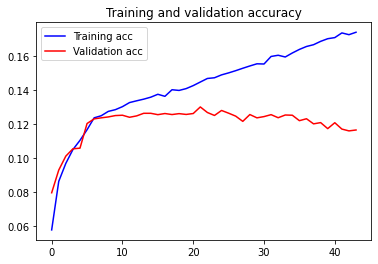

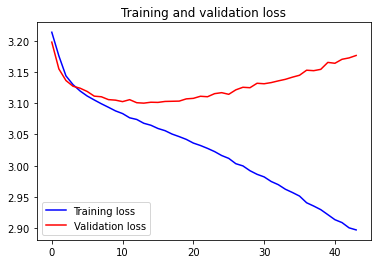

In [7]:
import matplotlib.pyplot as plt

def visualize_results(history):
    # Plot the accuracy and loss curves
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()


# Run the function to illustrate accuracy and loss
visualize_results(history)

In [8]:
test_scores

[1.823069453239441,
 0.7177143096923828,
 1.0,
 0.0028571428265422583,
 5.0,
 42000.0,
 0.0,
 1745.0]